In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data23668


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

In [ ]:

!cd /home/aistudio/data/data23668 && unzip -qo Dataset.zip
!cd /home/aistudio/data/data23668/Dataset && rm -f */.DS_Store # 删除无关文件 


In [ ]:
import os
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers
from multiprocessing import cpu_count
from paddle.fluid.dygraph import Pool2D,Conv2D,BatchNorm,Linear
from paddle.fluid.layers import dropout

In [ ]:

# 生成图像列表
data_path = '/home/aistudio/data/data23668/Dataset'
character_folders = os.listdir(data_path)
# print(character_folders)
if(os.path.exists('./train_data.list')):
    os.remove('./train_data.list')
if(os.path.exists('./test_data.list')):
    os.remove('./test_data.list')
    
for character_folder in character_folders:
    
    with open('./train_data.list', 'a') as f_train:
        with open('./test_data.list', 'a') as f_test:
            if character_folder == '.DS_Store':
                continue
            character_imgs = os.listdir(os.path.join(data_path,character_folder))
            count = 0 
            for img in character_imgs:
                if img =='.DS_Store':
                    continue
                if count%10 == 0:
                    f_test.write(os.path.join(data_path,character_folder,img) + '\t' + character_folder + '\n')
                else:
                    f_train.write(os.path.join(data_path,character_folder,img) + '\t' + character_folder + '\n')
                count +=1
print('列表已生成')


列表已生成


In [ ]:
# 定义训练集和测试集的reader
def data_mapper(sample):
    img, label = sample
    img = Image.open(img)
    img = img.resize((100, 100), Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1))
    img = img/255.0
    return img, label

def data_reader(data_list_path):
    def reader():
        with open(data_list_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img, label = line.split('\t')
                yield img, int(label)
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 512)
 

In [ ]:
# 用于训练的数据提供器
train_reader = paddle.batch(reader=paddle.reader.shuffle(reader=data_reader('./train_data.list'), buf_size=256), batch_size=32)
# 用于测试的数据提供器
test_reader = paddle.batch(reader=data_reader('./test_data.list'), batch_size=32) 


In [56]:
#定义VGG网络
class VGG(fluid.dygraph.Layer):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = Conv2D(3, 16, 3, act='relu')
        self.pool1 = Pool2D(pool_size=2,pool_type='max',pool_stride=2)
        self.conv2 = Conv2D(16, 32, 3, act='relu')
        self.pool2 = Pool2D(pool_size=2,pool_type='max',pool_stride=2)
        self.conv3 = Conv2D(32, 64, 3, act='relu')
        self.pool3 = Pool2D(pool_size=2,pool_type='max',pool_stride=2)
        self.conv4 = Conv2D(64, 128, 3, act='relu')
        self.conv5 = Conv2D(128, 128, 3, act='relu')
        self.linear1 = Linear(input_dim=4608, output_dim=2000, act='relu')# 6*6*128
        self.predict = Linear(input_dim=2000, output_dim=10, act='softmax')

# 网络的前向计算过程
    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = fluid.layers.reshape(x, shape=[-1,4608])
        x = self.linear1(x)
        y = self.predict(x)
        return y

In [57]:

#用动态图进行训练
with fluid.dygraph.guard():
    model=VGG() #模型实例化
    model.train() #训练模式
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.0001, parameter_list=model.parameters())

    epochs_num=60 #迭代次数
    
    for pass_num in range(epochs_num):
        
        for batch_id,data in enumerate(train_reader()):
            
            images=np.array([x[0].reshape(3,100,100) for x in data],np.float32)
            
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]
            # print(images.shape)
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)
            predict=model(image)#预测
            # print(predict)
            loss=fluid.layers.cross_entropy(predict,label)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            
            acc=fluid.layers.accuracy(predict,label)#计算精度
            
            if batch_id!=0 and batch_id%50==0:
                print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            
            avg_loss.backward()
            opt.minimize(avg_loss)
            model.clear_gradients()
            
    fluid.save_dygraph(model.state_dict(),'VGG')#保存模型
 

train_pass:0,batch_id:50,train_loss:[2.6271],train_acc:[0.]
train_pass:1,batch_id:50,train_loss:[2.4966547],train_acc:[0.]
train_pass:2,batch_id:50,train_loss:[2.448809],train_acc:[0.]
train_pass:3,batch_id:50,train_loss:[1.8209903],train_acc:[0.]
train_pass:4,batch_id:50,train_loss:[2.2724717],train_acc:[0.]
train_pass:5,batch_id:50,train_loss:[2.21947],train_acc:[0.]
train_pass:6,batch_id:50,train_loss:[2.1620855],train_acc:[0.375]
train_pass:7,batch_id:50,train_loss:[1.8917131],train_acc:[0.]
train_pass:8,batch_id:50,train_loss:[1.5466409],train_acc:[0.]
train_pass:9,batch_id:50,train_loss:[1.5328559],train_acc:[0.53125]
train_pass:10,batch_id:50,train_loss:[2.5383067],train_acc:[0.]
train_pass:11,batch_id:50,train_loss:[3.204555],train_acc:[0.]
train_pass:12,batch_id:50,train_loss:[1.9419727],train_acc:[0.46875]
train_pass:13,batch_id:50,train_loss:[2.3631542],train_acc:[0.]
train_pass:14,batch_id:50,train_loss:[2.1672559],train_acc:[0.]
train_pass:15,batch_id:50,train_loss:[1.9777

In [59]:
#模型校验
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('VGG')
    model = VGG()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(test_reader()):#测试集
        images=np.array([x[0].reshape(3,100,100) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]

        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)
        
        predict=model(image)       
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

0.9598214


(3, 100, 100)
5


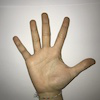

In [ ]:
#读取预测图像，进行预测

def load_image(path):
    img = Image.open(path)
    img = img.resize((100, 100), Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1))
    img = img/255.0
    print(img.shape)
    return img

#构建预测动态图过程
with fluid.dygraph.guard():
    infer_path = '手势.JPG'
    model=VGG()#模型实例化
    model_dict,_=fluid.load_dygraph('VGG')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    infer_img = load_image(infer_path)
    infer_img=np.array(infer_img).astype('float32')
    infer_img=infer_img[np.newaxis,:, : ,:]
    infer_img = fluid.dygraph.to_variable(infer_img)
    result=model(infer_img)
    display(Image.open('手势.JPG'))
    print(np.argmax(result.numpy()))